# Propagation use-case

In [2]:
import numpy as np
from numpy import exp, pi
from matplotlib import pyplot as plt

from blocksim.control.SetPoint import Step, Ramp
from blocksim.dsp.DSPSignal import DSPSignal
from blocksim.graphics import plotDSPLine
from blocksim.Simulation import Simulation

from blocksim.constants import c
from blocksim.dsp.DSPChannel import DSPChannel

[INFO] - Registered blocksim.loggers.CSVLogger
[INFO] - Registered blocksim.loggers.CSVLogger
[INFO] - Registered blocksim.loggers.PickleLogger
[INFO] - Registered blocksim.loggers.PickleLogger
[WARNING] - Failed to load blocksim.loggers.PsqlLogger
[WARNING] - Failed to load blocksim.loggers.PsqlLogger
[INFO] - Registered blocksim.loggers.XlsLogger
[INFO] - Registered blocksim.loggers.XlsLogger


We define the TX trajectory:

* constant velocity of 2,119.85 m/s on X, 0 on Y and Z
* initial position of -211,985.28 m on X and 211,985.28 m on Z

In [3]:
vel0 = np.zeros(6)
vel0[0] = 2119.85
pos0 = np.zeros(6)
pos0[0] = -211985.28
pos0[2] = 211985.28
pos0[3] = vel0[0]

tx = Ramp(name="tx", snames=["px", "py", "pz", "vx", "vy", "vz"], slopes=vel0)
tx.setInitialStateForOutput(initial_state=pos0, output_name="setpoint")

The receiver (RX) is fixed on the ground at (0, 0, 0)

In [4]:
rx = Step(
    name="rx",
    snames=["px", "py", "pz", "vx", "vy", "vz"],
    cons=np.zeros(6),
)

We set a gaussian propagation channel

In [5]:
chn = DSPChannel(
    name="chn",
    wavelength=c / 2e9,
    antenna_gain=0.0,
    antenna_temp=290.0,
    bandwidth=1e6,
    noise_factor=2.5,
    alpha=[0.3820e-7, 0.1490e-7, -0.1790e-6, 0.0000],
    beta=[0.1430e6, 0.0000, -0.3280e6, 0.1130e6],
    noatm=True,
)

We define a signal emitted by TX:

* pure wave of 5 kHz
* emission from t = 0 s to t = 1 ms
* sampled at 100 kHz

In [6]:
f0 = 5e3
fs = 100e3
tps = np.arange(100 * 5) / fs
x = exp(1j * 2 * pi * f0 * tps) * 100
inok = np.where(tps > 1e-3)[0]
x[inok] = 0.0
sig = DSPSignal.fromTimeAndSamples(name="sig", tps=tps, y_serie=x)

We simulate the setup

In [7]:
sim = Simulation([sig, tx, chn, rx])

sim.connect("sig.setpoint", "chn.txsig")
sim.connect("tx.setpoint", "chn.txpos")
sim.connect("rx.setpoint", "chn.rxpos")

sim.simulate(tps, progress_bar=False)
log = sim.getLogger()

/Users/ydethe/repos/blocksim/blocksim/utils.py:589: RuntimeWarning: invalid value encountered in true_divide
  vert /= lin.norm(vert)
/Users/ydethe/repos/blocksim/blocksim/utils.py:592: RuntimeWarning: invalid value encountered in true_divide
  east /= lin.norm(east)


We get the received signal, and compute its FFT

In [8]:
rxsig = log.getSignal("chn_rxsig_y")
sp = rxsig.fft()

We plot the signal and its FFT

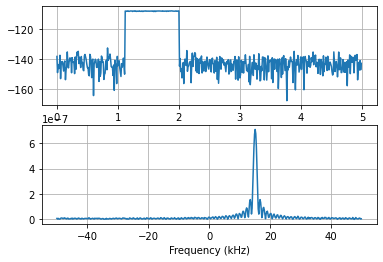

In [9]:
fig = plt.figure()
axe = fig.add_subplot(211)
axe.grid(True)
_ = plotDSPLine(rxsig, axe, transform=rxsig.to_db_lim(-200))

axe = fig.add_subplot(212)
axe.grid(True)
_ = plotDSPLine(sp, axe)